In [ ]:
!pip install stellargraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 435 kB 9.6 MB/s 


In [ ]:
# Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd # Pandas to create small dataframes 
import numpy as np
import datetime # Convert to unix time
import time # Convert to unix time
# If numpy is not installed already : pip3 install numpy
import numpy as np # Do aritmetic operations on arrays
# Matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns # Plots
from matplotlib import rcParams # Size of plots  
import math
import pickle
import os
# To install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
from tqdm.notebook import tqdm
import random
from sklearn.model_selection import train_test_split
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint as sp_randint
from xgboost import XGBClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_path = "gdrive/My Drive/Major Project/wiki/"

In [ ]:
df_train = pd.read_csv(data_path+"pos_train_91.csv", index_col = 0)

In [ ]:
df_train.head()

,src,dest,link
33079,1332,1211,1
100635,6224,3649,1
61866,2909,2439,1
86957,4753,2163,1
103670,7082,5806,1


In [ ]:
import tensorflow

In [ ]:
from stellargraph.core import StellarGraph
from stellargraph.mapper import AdjacencyPowerGenerator
from stellargraph.layer import WatchYourStep
from stellargraph.losses import graph_log_likelihood
from stellargraph.utils import plot_history

from tensorflow.keras import optimizers, Model, layers, regularizers
import tensorflow as tf

In [ ]:
train_graph = nx.from_pandas_edgelist(df_train, source='src', target='dest', create_using=nx.MultiDiGraph())

In [ ]:
G = StellarGraph.from_networkx(train_graph)

In [ ]:
generator = AdjacencyPowerGenerator(G, num_powers = 3)

In [ ]:
wys = WatchYourStep(
    generator,
    num_walks=80,
    embedding_dimension=64,
    attention_regularizer=regularizers.l2(0.5),
)
x_in, x_out = wys.in_out_tensors()

In [ ]:
model = Model(inputs = x_in, outputs = x_out)
model.compile(loss=graph_log_likelihood, optimizer=tf.keras.optimizers.Adam(1e-2))

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor='loss',
    patience = 1,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
epochs = 50
batch_size = 100
train_gen = generator.flow(batch_size=batch_size)
history = model.fit(
    train_gen, epochs=epochs, verbose=1, steps_per_epoch=int(len(G.nodes()) // batch_size), callbacks = [es]
)

Epoch 1/50
71/71 [==============================] - 25s 262ms/step - loss: 495168.6562
Epoch 2/50
71/71 [==============================] - 18s 256ms/step - loss: 298660.1562
Epoch 3/50
71/71 [==============================] - 18s 257ms/step - loss: 30569.8418
Epoch 4/50
71/71 [==============================] - 12s 167ms/step - loss: 18582.7480
Epoch 5/50
71/71 [==============================] - 12s 167ms/step - loss: 17213.2031
Epoch 6/50
71/71 [==============================] - 12s 166ms/step - loss: 16471.3789
Epoch 7/50
71/71 [==============================] - 13s 178ms/step - loss: 16001.4727
Epoch 8/50
71/71 [==============================] - 12s 167ms/step - loss: 15698.0205
Epoch 9/50
71/71 [==============================] - 12s 168ms/step - loss: 15465.2021
Epoch 10/50
71/71 [==============================] - 13s 190ms/step - loss: 15255.4795
Epoch 11/50
71/71 [==============================] - 12s 166ms/step - loss: 15096.4053
Epoch 12/50
71/71 [==============================]

In [ ]:
model_file = open(data_path+"wys_model_91.h5", "wb")
pickle.dump(model, model_file)
model_file.close()

INFO:tensorflow:Assets written to: ram://95946eaa-e01d-44a0-9617-6015e5fcef09/assets


In [ ]:
embeddings = wys.embeddings()

In [ ]:
emb_file = open(data_path+"wys_embeddings_91.pkl", "wb")
pickle.dump(embeddings, emb_file)
emb_file.close()

In [ ]:
emb_file = open(data_path+"wys_embeddings_91.pkl", "rb")
embeddings = pickle.load(emb_file)
emb_file.close()
embeddings.shape

(7115, 64)

In [ ]:
nodes = list(G.nodes())
nodes[:5]

[1332, 1211, 6224, 3649, 2909]

In [ ]:
emb_dict = {}
for i, node in enumerate(nodes):
  emb_dict[node] = np.array(embeddings[i].reshape(1,64))

In [ ]:
combined_tr = pd.read_csv(data_path+"train_91.csv", index_col = 0)
print(combined_tr.shape)
combined_tr.head()

(187022, 3)


,src,dest,link
11538,308,75,1
2338,3874,251,0
89956,1506,4335,0
54348,2471,4066,1
91913,1584,2951,0


In [ ]:
# get training embeddings
train_emb = []
for i, row in tqdm(combined_tr.iterrows()):
  comb_emb = (emb_dict[row['src']]) * (emb_dict[row['dest']])
  train_emb.append(comb_emb[0])
train_emb = np.array(train_emb)

0it [00:00, ?it/s]

In [ ]:
train_y = combined_tr['link']
len(train_y)

187022

In [ ]:
combined_test = pd.read_csv(data_path+"test_91.csv", index_col = 0)
combined_test.head()

,src,dest,link
13017,415,81,1
98801,2230,1590,0
4421,67,4680,1
57102,2633,2303,1
62449,2999,698,1


In [ ]:
# get test embeddings
test_emb = []
for i, row in tqdm(combined_test.iterrows()):
  comb_emb = (emb_dict[row['src']]) * (emb_dict[row['dest']])
  test_emb.append(comb_emb[0])

print(len(test_emb), len(test_emb[0]))
test_emb = np.array(test_emb)
print(test_emb.shape)
test_y = combined_test['link'] 

0it [00:00, ?it/s]

20667 64
(20667, 64)


In [ ]:
#reading
from pandas import read_hdf
df_final_train = read_hdf(data_path + 'storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf(data_path + 'storage_sample_stage4.h5', 'test_df',mode='r')

In [ ]:
df_final_train.columns

Index(['src', 'dest', 'link', 'jaccard_followers', 'jaccard_followees',
       'cosine_followers', 'cosine_followees', 'num_followers_s',
       'num_followers_d', 'num_followees_s', 'num_followees_d',
       'inter_followers', 'inter_followees', 'adar_index', 'follows_back',
       'same_comp', 'shortest_path', 'weight_in', 'weight_out', 'weight_f1',
       'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d',
       'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'svd_dot_u', 'svd_dot_v', 'pref_attach_er', 'pref_attach_ee'],
      dtype='object')

In [ ]:
df_final_train.shape

(187022, 59)

In [ ]:
y_train = df_final_train.link
y_test = df_final_test.link

In [ ]:
df_final_train.drop(['src', 'dest','link'],axis=1,inplace=True)
df_final_test.drop(['src', 'dest','link'],axis=1,inplace=True)

In [ ]:
# WYS only
clf = XGBClassifier(max_depth=7, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(train_emb, train_y)
train_sc = f1_score(train_y,clf.predict(train_emb))
test_sc = f1_score(test_y,clf.predict(test_emb))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9166232385283916 test Score 0.898000191369247


In [ ]:
# WYS only
clf = RandomForestClassifier(max_depth=12, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(train_emb, train_y)
train_sc = f1_score(train_y,clf.predict(train_emb))
test_sc = f1_score(test_y,clf.predict(test_emb))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9181785563858166 test Score 0.8914150943396226


In [ ]:
# WYS only
from lightgbm import LGBMClassifier
clf = LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, 
                     objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
                     subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=- 1, importance_type='split')
clf.fit(train_emb, train_y)
train_sc = f1_score(train_y,clf.predict(train_emb))
test_sc = f1_score(test_y,clf.predict(test_emb))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9057811097618922 test Score 0.8953304218457552


In [ ]:
# Heuristic only
clf = XGBClassifier(max_depth=7, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9856018983688566 test Score 0.9665368882755901


In [ ]:
# Heuristic only
clf = RandomForestClassifier(max_depth=12, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.981759433534703 test Score 0.9604033086975674


In [ ]:
# Heuristic only
clf = LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, 
                     objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
                     subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=- 1, importance_type='split')
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9844932244688583 test Score 0.9676879125209339


In [ ]:
df_final_train = np.hstack((df_final_train, train_emb))
print(df_final_train.shape)
df_final_test = np.hstack((df_final_test, test_emb))
print(df_final_test.shape)

(187022, 120)
(20667, 120)


In [ ]:
print(type(train_y), type(y_train))
for i in range(len(y_train.values)):
  if train_y.values[i] != y_train.values[i]: print(i)

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [ ]:
# Heuristic + WYS
clf = XGBClassifier(max_depth=7, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9865613661987636 test Score 0.9661058759682274


In [ ]:
# Heuristic + WYS
clf = RandomForestClassifier(max_depth=12, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9820814075322976 test Score 0.959937463357436


In [ ]:
# Heuristic + WYS
clf = LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, 
                     objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
                     subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=- 1, importance_type='split')
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9856484895115357 test Score 0.9667488899851998


Estimators =  100 Train Score 0.9696319279156749 test Score 0.9572257718382675


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

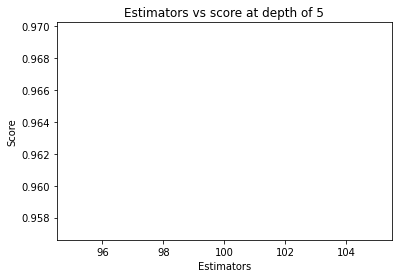

In [ ]:
estimators = [100]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

Estimators =  100 Train Score 0.9915559317314427 test Score 0.9452121726143833


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

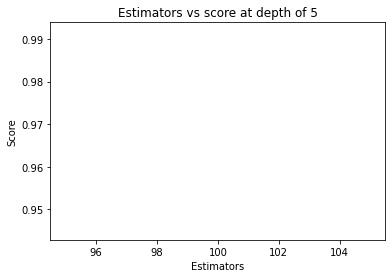

In [ ]:
estimators = [100]
train_scores = []
test_scores = []
for i in estimators:
    clf = XGBClassifier(max_depth=12, learning_rate=0.1, n_estimators=i, verbosity=1, objective='binary:logistic', 
                        booster='gbtree', tree_method='auto', n_jobs=1, gamma=0, min_child_weight=1, 
                        max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, 
                        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, missing=None)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

In [ ]:
train_emb_sample.shape

In [ ]:
param_dist = {"n_estimators":sp_randint(50,200),
              "max_depth": sp_randint(5,20),
              "learning rate": sp_randfloat(0.001,1)}

clf = LGBMClassifier(random_state=25,n_jobs=-1)

lgb_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=10,cv=5,scoring='f1',random_state=25, return_train_score = True, verbose = 10)

lgb_random.fit(df_final_train,train_y)
print('mean test scores',lgb_random.cv_results_['mean_test_score'])
print('mean train scores',lgb_random.cv_results_['mean_train_score'])
print(lgb_random.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START learning rate=0, max_depth=9, n_estimators=112.............
[CV 1/5; 1/10] END learning rate=0, max_depth=9, n_estimators=112;, score=(train=0.983, test=0.983) total time=  59.9s
[CV 2/5; 1/10] START learning rate=0, max_depth=9, n_estimators=112.............
[CV 2/5; 1/10] END learning rate=0, max_depth=9, n_estimators=112;, score=(train=0.983, test=0.982) total time=  59.6s
[CV 3/5; 1/10] START learning rate=0, max_depth=9, n_estimators=112.............
[CV 3/5; 1/10] END learning rate=0, max_depth=9, n_estimators=112;, score=(train=0.984, test=0.983) total time= 1.0min
[CV 4/5; 1/10] START learning rate=0, max_depth=9, n_estimators=112.............
[CV 4/5; 1/10] END learning rate=0, max_depth=9, n_estimators=112;, score=(train=0.984, test=0.982) total time= 1.0min
[CV 5/5; 1/10] START learning rate=0, max_depth=9, n_estimators=112.............
[CV 5/5; 1/10] END learning rate=0, max_depth=9, n_estimat

In [ ]:
lgb_random.best_params_

{'learning rate': 0, 'max_depth': 15, 'n_estimators': 193}

In [ ]:
%%time
clf = LGBMClassifier(learning_rate=0.01, max_depth=15, n_estimators=160, random_state=25)
clf.fit(df_final_train, train_y)
train_sc = f1_score(train_y,clf.predict(df_final_train))
test_sc = f1_score(test_y,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9772666452875672 test Score 0.9505805462246238
CPU times: user 3min 22s, sys: 401 ms, total: 3min 23s
Wall time: 1min 45s


In [ ]:
param_dist = {
    "boosting_type": ['gbdt', 'dart', 'goss', 'rf'],
    "learning_rate": [0.001, 0.01, 0.05, 0.5, 1],
    "num_leaves": [15, 31, 63]
}

clf = LGBMClassifier(n_estimators = 160, max_depth = 15, random_state=25, n_jobs=-1)

lgb_random = GridSearchCV(clf, param_grid=param_dist, cv=3, scoring='f1', return_train_score = True, verbose = 10)

lgb_random.fit(df_final_train,train_y)
print('mean test scores',lgb_random.cv_results_['mean_test_score'])
print('mean train scores',lgb_random.cv_results_['mean_train_score'])
print(lgb_random.best_estimator_)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV 1/3; 1/60] START boosting_type=gbdt, learning_rate=0.001, num_leaves=15.....
[CV 1/3; 1/60] END boosting_type=gbdt, learning_rate=0.001, num_leaves=15;, score=(train=0.971, test=0.971) total time=  58.2s
[CV 2/3; 1/60] START boosting_type=gbdt, learning_rate=0.001, num_leaves=15.....
[CV 2/3; 1/60] END boosting_type=gbdt, learning_rate=0.001, num_leaves=15;, score=(train=0.971, test=0.971) total time=  56.7s
[CV 3/3; 1/60] START boosting_type=gbdt, learning_rate=0.001, num_leaves=15.....
[CV 3/3; 1/60] END boosting_type=gbdt, learning_rate=0.001, num_leaves=15;, score=(train=0.971, test=0.970) total time=  56.9s
[CV 1/3; 2/60] START boosting_type=gbdt, learning_rate=0.001, num_leaves=31.....
[CV 1/3; 2/60] END boosting_type=gbdt, learning_rate=0.001, num_leaves=31;, score=(train=0.975, test=0.976) total time= 1.2min
[CV 2/3; 2/60] START boosting_type=gbdt, learning_rate=0.001, num_leaves=31.....
[CV 2/3; 2/60] END boosti

In [ ]:
%%time
clf = LGBMClassifier(learning_rate=0.05, max_depth=15, n_estimators=160, num_leaves = 63, random_state=25)
clf.fit(df_final_train, train_y)
train_sc = f1_score(train_y,clf.predict(df_final_train))
test_sc = f1_score(test_y,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9846376311704851 test Score 0.9462624997698016
CPU times: user 4min 34s, sys: 566 ms, total: 4min 34s
Wall time: 2min 34s


In [ ]:
%%time
clf = LGBMClassifier(boosting_type = 'goss', learning_rate=0.01, max_depth=15, n_estimators=160, num_leaves = 63, random_state=25)
clf.fit(df_final_train, train_y)
train_sc = f1_score(train_y,clf.predict(df_final_train))
test_sc = f1_score(test_y,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9793682551767486 test Score 0.9475895986640487
CPU times: user 3min 51s, sys: 611 ms, total: 3min 52s
Wall time: 2min 3s


In [ ]:
%%time
clf = LGBMClassifier(learning_rate=0.01, max_depth=15, n_estimators=160, random_state=25)
clf.fit(df_final_train, train_y)
train_sc = f1_score(train_y,clf.predict(df_final_train))
test_sc = f1_score(test_y,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9772666452875672 test Score 0.9505805462246238
CPU times: user 3min 22s, sys: 429 ms, total: 3min 22s
Wall time: 1min 45s


In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [ ]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

Train confusion_matrix


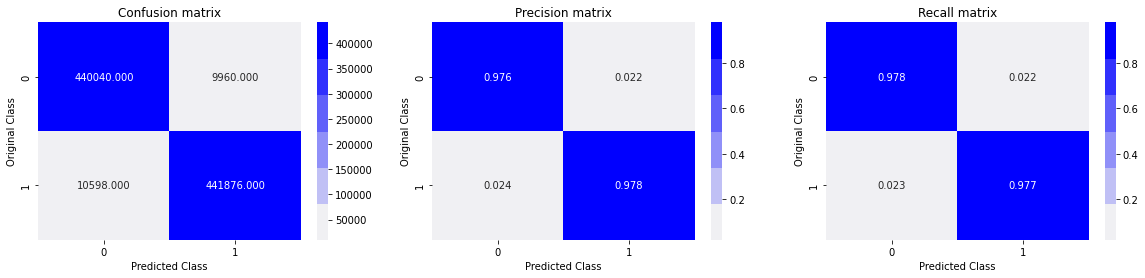

Test confusion_matrix


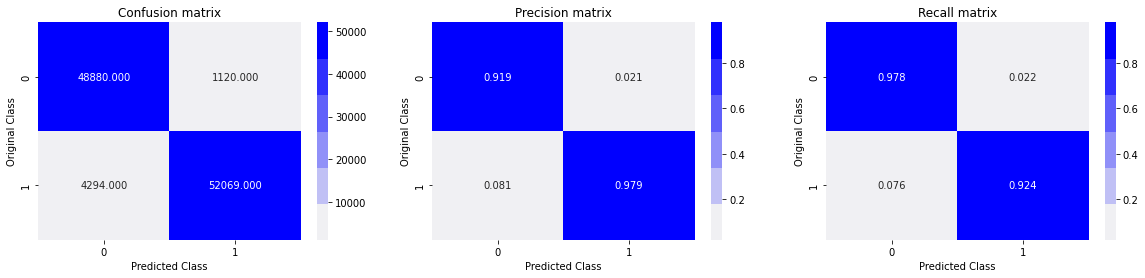

In [ ]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

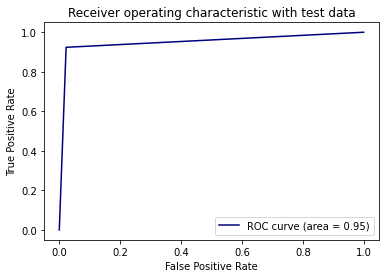

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

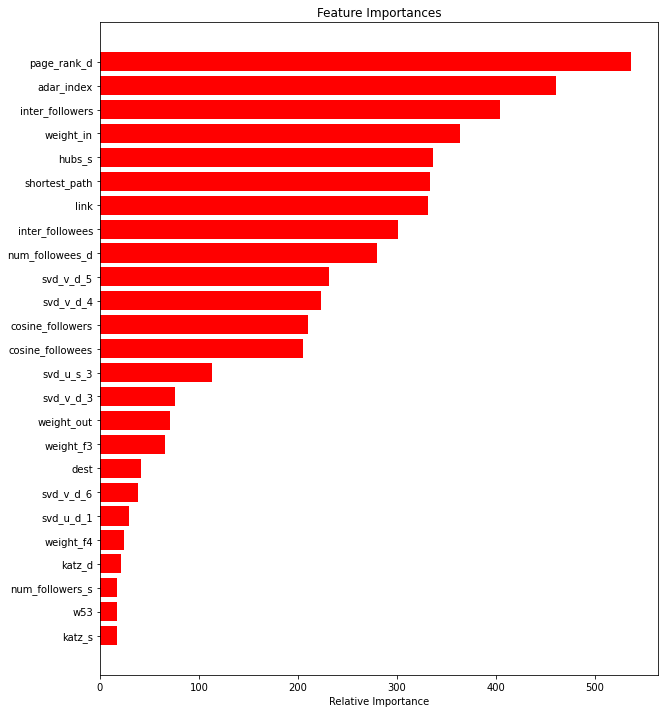

In [ ]:
features = ['src', 'dest', 'link', 'jaccard_followers', 'jaccard_followees',
       'cosine_followers', 'cosine_followees', 'num_followers_s',
       'num_followers_d', 'num_followees_s', 'num_followees_d',
       'inter_followers', 'inter_followees', 'adar_index', 'follows_back',
       'same_comp', 'shortest_path', 'weight_in', 'weight_out', 'weight_f1',
       'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d',
       'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'svd_dot_u', 'svd_dot_v', 'pref_attach_er', 'pref_attach_ee'] + ['w' + str(i) for i in range(1, 65)]

importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()